## MMA 860 Team Project: Predicting Housing Prices

Team Istanbul

In [301]:
# %pip install openpyxl
# %matplotlib inline
# %pip install statsmodels
# %pip install scikit-learn seaborn
# %pip install jupyter_contrib_nbextensions
# %pip install --upgrade scikit-learn

In [302]:
import os

import pandas as pd
import numpy as np

import statsmodels.imputation.mice as mice
import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.stats.diagnostic import het_breuschpagan

from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Lasso
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn import linear_model
from sklearn.metrics import mean_absolute_error, mean_squared_error

from patsy import dmatrices
import scipy.stats as stats

import matplotlib.pyplot as plt
import seaborn as sns

In [303]:
#Converting data source to dataframes
file_path_test  = "test.csv"
file_path_train = "train.csv"

df_test  = pd.read_csv(file_path_test)
df_train = pd.read_csv(file_path_train)

In [304]:
df_combined = pd.concat([df_train, df_test], ignore_index=True)

In [305]:
df_combined.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500.0
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500.0
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500.0
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000.0
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000.0


## Project Code

### Data Cleaning
1. Check for nulls
2. Check of data-type inconsistencies
3. Check for duplicate rows
4. Check for outliers
5. Test for biases after imputations


In [306]:
#checking for datatype
print(df_combined.dtypes)

#Print column with inconsistent datatypes (if any)
for col in df_combined.columns:
    unique_types = set(df_combined[col].dropna().apply(type)) 
    if len(unique_types) > 1:
        print(f"Column '{col}' has inconsistent data types: {unique_types}")

Id                 int64
MSSubClass         int64
MSZoning          object
LotFrontage      float64
LotArea            int64
                  ...   
MoSold             int64
YrSold             int64
SaleType          object
SaleCondition     object
SalePrice        float64
Length: 81, dtype: object


In [307]:
df_combined.shape

(2919, 81)

In [308]:
#check for duplicates
duplicate_count = df_combined.duplicated().sum()
print(f"Number of duplicate rows: {duplicate_count}")

Number of duplicate rows: 0


In [309]:
cols = df_combined.columns.tolist()

#Checking column names; removing spaces from name
for col in cols:
    if ' ' in col:
        new_col = col.replace(' ', '')
        print(f"Removing space in {col}: new name {new_col}")
        
        df_combined.rename(columns={col: new_col}, inplace=True)

In [310]:
#Checking if any columns are completely empty
for col in cols:
    if df_combined[col].astype(str).str.strip().eq('').all():
        print(f"Column {col} is empty. To be deleted...")

In [311]:
#Checking for nulls in columns (grouped by datatype)

#Initializing lists to store column names with null values
col_num_nulls = []
col_obj_nulls = []

for dtype in sorted(df_combined.dtypes.unique(), key=str):  
    
    # Select columns of the current data type and sort by null count
    cols = [col for col in df_combined.columns if df_combined[col].dtypes == dtype]
    sorted_cols = sorted(cols, key=lambda col: df_combined[col].isnull().sum(), reverse=True)
    
    if df_combined[col].isnull().sum() == 0:
        print(f"------------- {dtype} -------------")
    
    # Print columns and their respective null counts
    for col in sorted_cols:
        null_count = df_combined[col].isnull().sum()
        if null_count > 0:
            print(f"{col} : {null_count}")
            
            #Storing column names in the lists
            if dtype == 'object':
                col_obj_nulls.append(col)
            else:
                col_num_nulls.append(col)

    print("\n")

SalePrice : 1459
LotFrontage : 486
GarageYrBlt : 159
MasVnrArea : 23
BsmtFullBath : 2
BsmtHalfBath : 2
BsmtFinSF1 : 1
BsmtFinSF2 : 1
BsmtUnfSF : 1
TotalBsmtSF : 1
GarageCars : 1
GarageArea : 1




------------- object -------------
PoolQC : 2909
MiscFeature : 2814
Alley : 2721
Fence : 2348
FireplaceQu : 1420
GarageFinish : 159
GarageQual : 159
GarageCond : 159
GarageType : 157
BsmtCond : 82
BsmtExposure : 82
BsmtQual : 81
BsmtFinType2 : 80
BsmtFinType1 : 79
MasVnrType : 24
MSZoning : 4
Utilities : 2
Functional : 2
Exterior1st : 1
Exterior2nd : 1
Electrical : 1
KitchenQual : 1
SaleType : 1




<h6 style="color: #ff5733;">Null Count Findings:</h6>

1. No spaces found in column names. 
2. There are no columns that are completely empty. 
3. There are no duplicate rows.

**Float Data Type**
1. There are 3 float type columns with null values. 
2. The maximum number of null values in a column are 259. 
3. All null values can be populated using multiple imputations

**Object Data Type**
1. There are 22 object type columns with null values. 
2. There are 4 columns that are more than 45% empty (i.e. less than 55% populated), therefore these columns must be deleted to prevent model skewing: <br>
&nbsp;&nbsp;&nbsp;&nbsp;<table>
    <tr>
        <th>Column</th>
        <th>Null Values</th>
        <th>Percent Empty</th>
    </tr>
    <tr>
        <td>PoolQC</td>
        <td>1453</td>
        <td>99.5%</td>
    </tr>
    <tr>
        <td>MiscFeature</td>
        <td>1406</td>
        <td>96.3%</td>
    </tr>
    <tr>
        <td>Alley</td>
        <td>1369</td>
        <td>93.8%</td>
    </tr>
    <tr>
        <td>Fence</td>
        <td>1179</td>
        <td>80.7%</td>
    </tr>
    <tr>
        <td>FireplaceQu</td>
        <td>690</td>
        <td>47.3%</td>
    </tr>
</table>
<br>3. For the remainder columns, 'None' will replace any empty values in the column. Using 'None' implies that the feature doesn't apply to that record. Adding another value could incorrectly skew the weight & outcome of that column. After adding 'None', <span style="background-color: yellow;"> we need to ensure the value/area of the corresponding feature is 0 (as imputation could add a non-zero value to it.</span> 

In [312]:
#Running multiple imputations on numeric columns feat
df_numeric = df_combined.loc[:, col_num_nulls]
imp        = mice.MICEData(df_numeric)
imp.next_sample()

imputed_data = imp.data

# Update df_combined with the imputed values
for col in df_numeric.columns:
    df_combined[col] = df_combined[col].where(df_combined[col].notnull(), imputed_data[col])

In [313]:
#Replacing null values in object columns with 'None'
for col in col_obj_nulls:
    df_combined[col] = df_combined[col].fillna('None')

#Dropping columns that more than 45% empty 
df_combined = df_combined.drop(['PoolQC', 'MiscFeature', 'Alley', 'Fence', 'FireplaceQu'], axis = 1)

In [314]:
#Checking no null values remain
cols = df_combined.columns.tolist()

for col in cols:
    null_count = df_combined[col].isnull().sum()
    if null_count > 0:
        print(f"{col} : {null_count}")

In [315]:
#Ensuring the value/area of the corresponding feature is 0

#If BsmtQual == None then TotalBsmtSF and TotalBsmtSF should be 0
df_combined.loc[df_combined['BsmtQual'].isnull(), ['TotalBsmtSF', 'BsmtUnfSF']] = 0

#If BsmtFinType2 == None then BsmtFinSF2 should be 0
df_combined.loc[df_combined['BsmtFinType2'].isnull(), ['BsmtFinSF2']] = 0

#If BsmtFinType1 == None then BsmtFinSF1 should be 0
df_combined.loc[df_combined['BsmtFinType1'].isnull(), ['BsmtFinSF1']] = 0

In [316]:
#Checking the above logic is being followed (value/area when feature doesn't exist should be 0)

logic_violated = False

#Check for basement quality vs total basement area & unfinished basement area
if not df_combined.loc[df_combined['BsmtQual'].isnull() & 
                    ((df_combined['TotalBsmtSF'] != 0) | (df_combined['BsmtUnfSF'] != 0))].empty:
    print("Rows violating BsmtQual logic:")
    print(df_combined.loc[df_combined['BsmtQual'].isnull() & 
                       ((df_combined['TotalBsmtSF'] != 0) | (df_combined['BsmtUnfSF'] != 0))])

#Check for first basement quality and first basement area
if not df_combined.loc[df_combined['BsmtFinType1'].isnull() & 
                (df_combined['BsmtFinSF1'] != 0)].empty:
    print("\nRows violating BsmtFinType1 logic:")
    print(df_combined.loc[df_combined['BsmtFinType1'].isnull() & 
                       (df_combined['BsmtFinSF1'] != 0)])

#Check for second basement quality and second basement are
if not df_combined.loc[df_combined['BsmtFinType2'].isnull() & 
                    (df_combined['BsmtFinSF2'] != 0)].empty:
    print("\nRows violating BsmtFinType2 logic:")
    print(df_combined.loc[df_combined['BsmtFinType2'].isnull() & 
                       (df_combined['BsmtFinSF2'] != 0)])

if not logic_violated:
    print("No logic violated.")


No logic violated.


<h5 style="color: blue;">Numeric Columns</h5>

1. Test numeric columns
2. Clean and add data wherever necessary

### Exploratory Data Analysis
1. Statistical analysis of variables


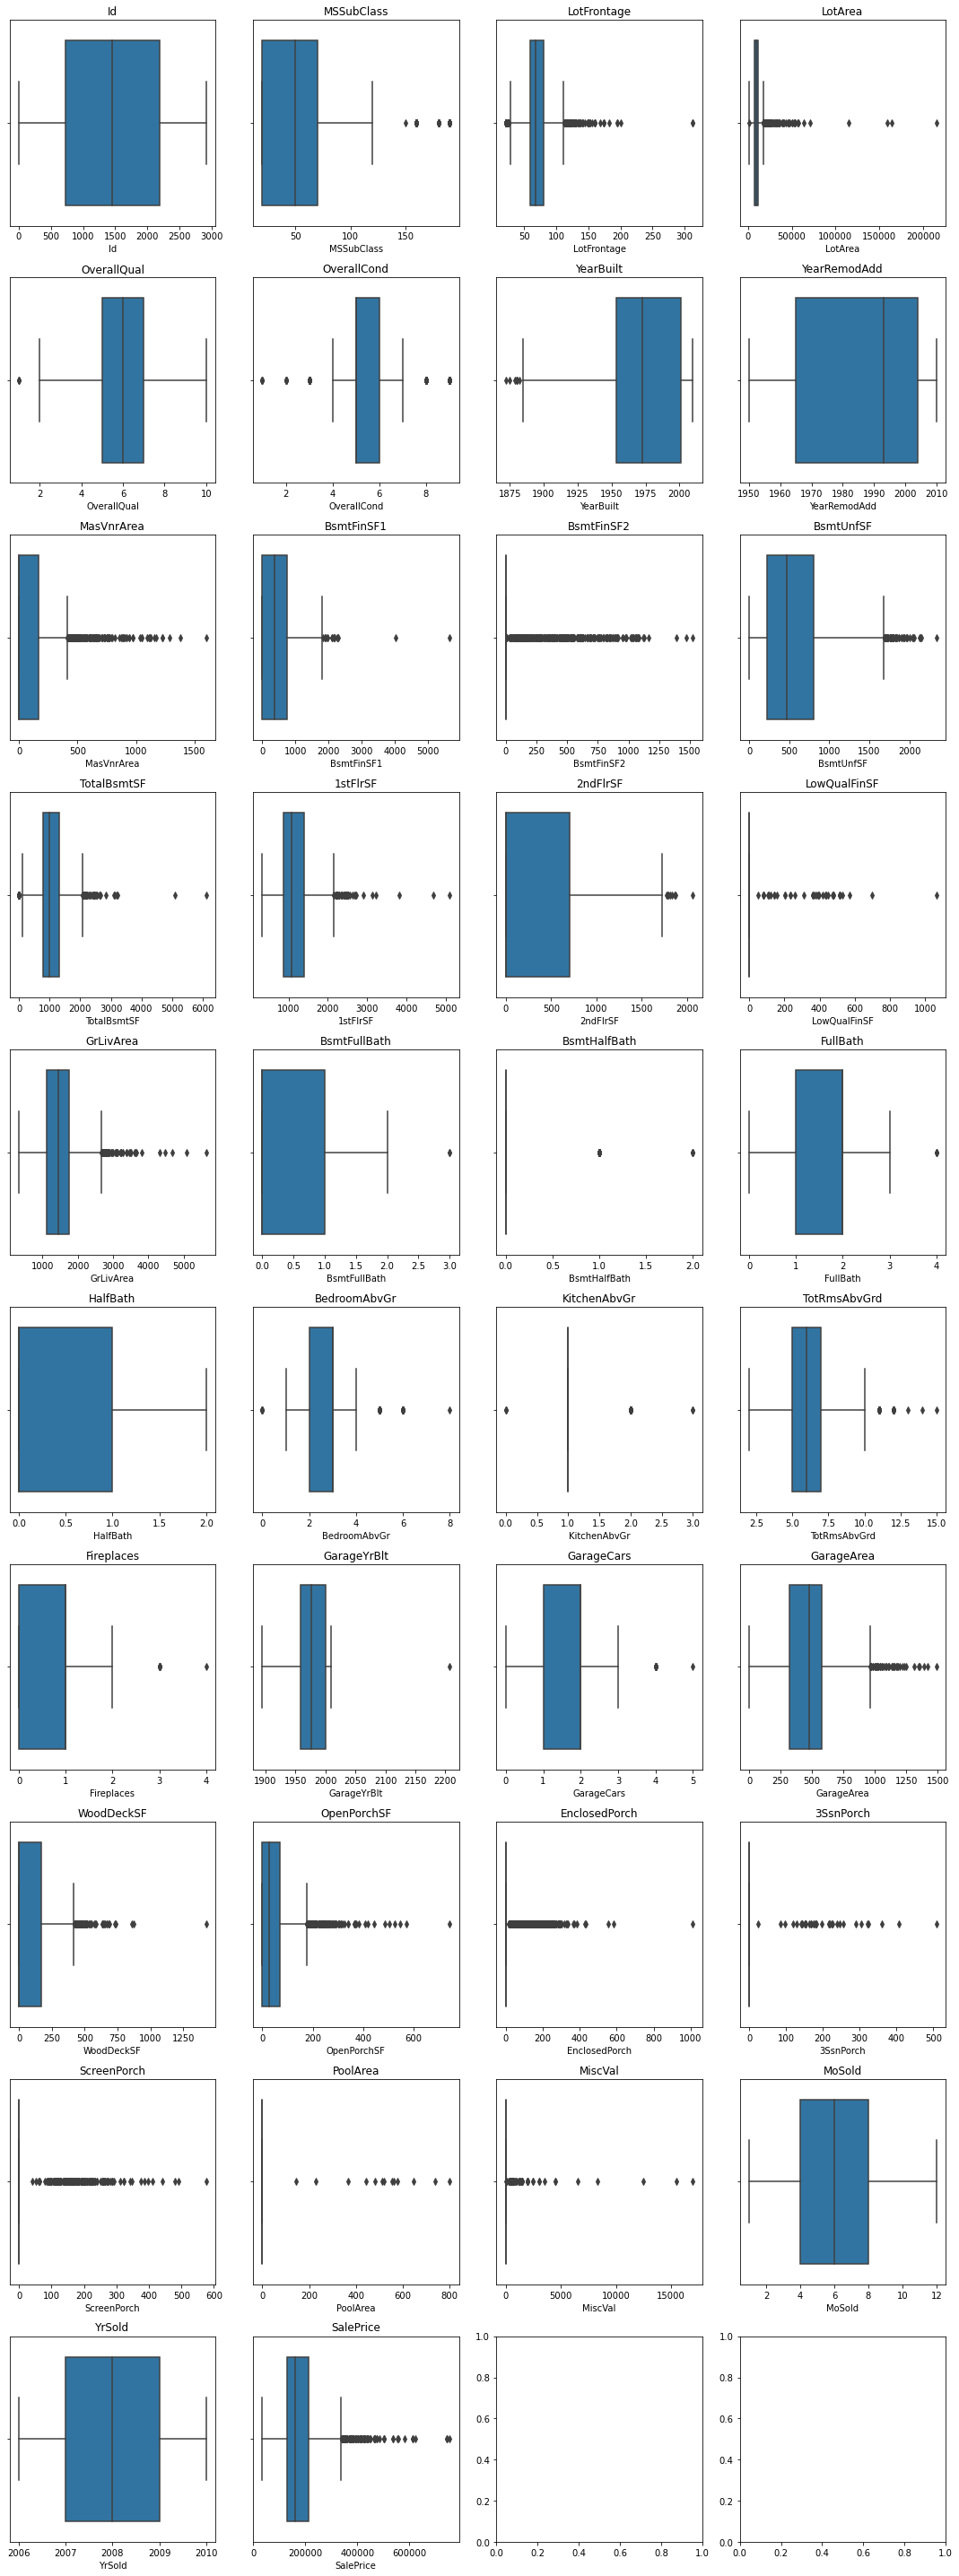

In [317]:
num_cols = df_combined.select_dtypes(include=['float64', 'int64']).columns.tolist()

# Define the number of plots per row
plots_per_row = 4
num_cols_count = len(num_cols)
rows = (num_cols_count // plots_per_row) + (num_cols_count % plots_per_row > 0) 

# Create subplots
fig, axes = plt.subplots(rows, plots_per_row, figsize=(15, rows * 4))
axes = axes.flatten()  # Flatten in case of multiple rows

# Box plot for each numeric column
for i, col in enumerate(num_cols):
    sns.boxplot(x=df_combined[col], ax=axes[i])
    axes[i].set_title(f'{col}')
plt.tight_layout()
plt.show()

<h6 style="color: #ff5733;">Outlier Findings:</h6>

A lot numeric columns contain outliers (as can be seen in the box and whisker plots), however it isn't necessary to remove the outliers because:
1. **Area columns:** For features related to area, the value of 0 is the most frequent value, representing unfinished or non-existent features. In these cases, other values are technically outliers, but 0 simply indicates the absence of that feature. Removing them would misrepresent the data.
2. **Condition columns:** These columns contain ratings for various aspects of the house, such as its condition. While extreme low or high ratings may appear as outliers, they actually reflect the true condition of the house. Removing these values would distort the representation of house conditions.
3. **Age columns:** These columns can be combined, the difference of Year Sold and Year Built can be used to create a new column Age Sold


Columns to be removed
MasVnrArea

| Column | Logic |
| :--- | :--- |
| MasVnrArea | 0s are overrepresented and can skew the data|
| KitchenAbvGr| Only has one value |
| PoolArea| 0s overrepresented |
| EnclosedPorch <br> 3SsnPorch <br> ScreenPorch| 0s overrepresented all other points are statistically outliers |


In [318]:
#Combining Year Sold and Year Built columns into Age Sold
df_combined['AgeSold'] = df_combined['YrSold'] - df_combined['YearBuilt']

df_combined = df_combined.drop(columns = ['YrSold', 'YearBuilt', 'KitchenAbvGr', 'PoolArea', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch' ])

In [319]:
df_combined = df_combined.drop(columns = ['MasVnrArea'])

<h5 style="color: blue;">Categorical Columns</h5>

1. Test categorical columns
2. Clean and add data wherever necessary

In [320]:
#Checking for distinct values in all colums of datatype 'object'
cat_cols = df_combined.select_dtypes(include=['object']).columns.tolist()

# 
for col in cat_cols:
    print(f"In column {col}: ")
    print(df_combined[col].unique())
    print("\n")

In column MSZoning: 
['RL' 'RM' 'C (all)' 'FV' 'RH' 'None']


In column Street: 
['Pave' 'Grvl']


In column LotShape: 
['Reg' 'IR1' 'IR2' 'IR3']


In column LandContour: 
['Lvl' 'Bnk' 'Low' 'HLS']


In column Utilities: 
['AllPub' 'NoSeWa' 'None']


In column LotConfig: 
['Inside' 'FR2' 'Corner' 'CulDSac' 'FR3']


In column LandSlope: 
['Gtl' 'Mod' 'Sev']


In column Neighborhood: 
['CollgCr' 'Veenker' 'Crawfor' 'NoRidge' 'Mitchel' 'Somerst' 'NWAmes'
 'OldTown' 'BrkSide' 'Sawyer' 'NridgHt' 'NAmes' 'SawyerW' 'IDOTRR'
 'MeadowV' 'Edwards' 'Timber' 'Gilbert' 'StoneBr' 'ClearCr' 'NPkVill'
 'Blmngtn' 'BrDale' 'SWISU' 'Blueste']


In column Condition1: 
['Norm' 'Feedr' 'PosN' 'Artery' 'RRAe' 'RRNn' 'RRAn' 'PosA' 'RRNe']


In column Condition2: 
['Norm' 'Artery' 'RRNn' 'Feedr' 'PosN' 'PosA' 'RRAn' 'RRAe']


In column BldgType: 
['1Fam' '2fmCon' 'Duplex' 'TwnhsE' 'Twnhs']


In column HouseStyle: 
['2Story' '1Story' '1.5Fin' '1.5Unf' 'SFoyer' 'SLvl' '2.5Unf' '2.5Fin']


In column RoofStyle: 
[

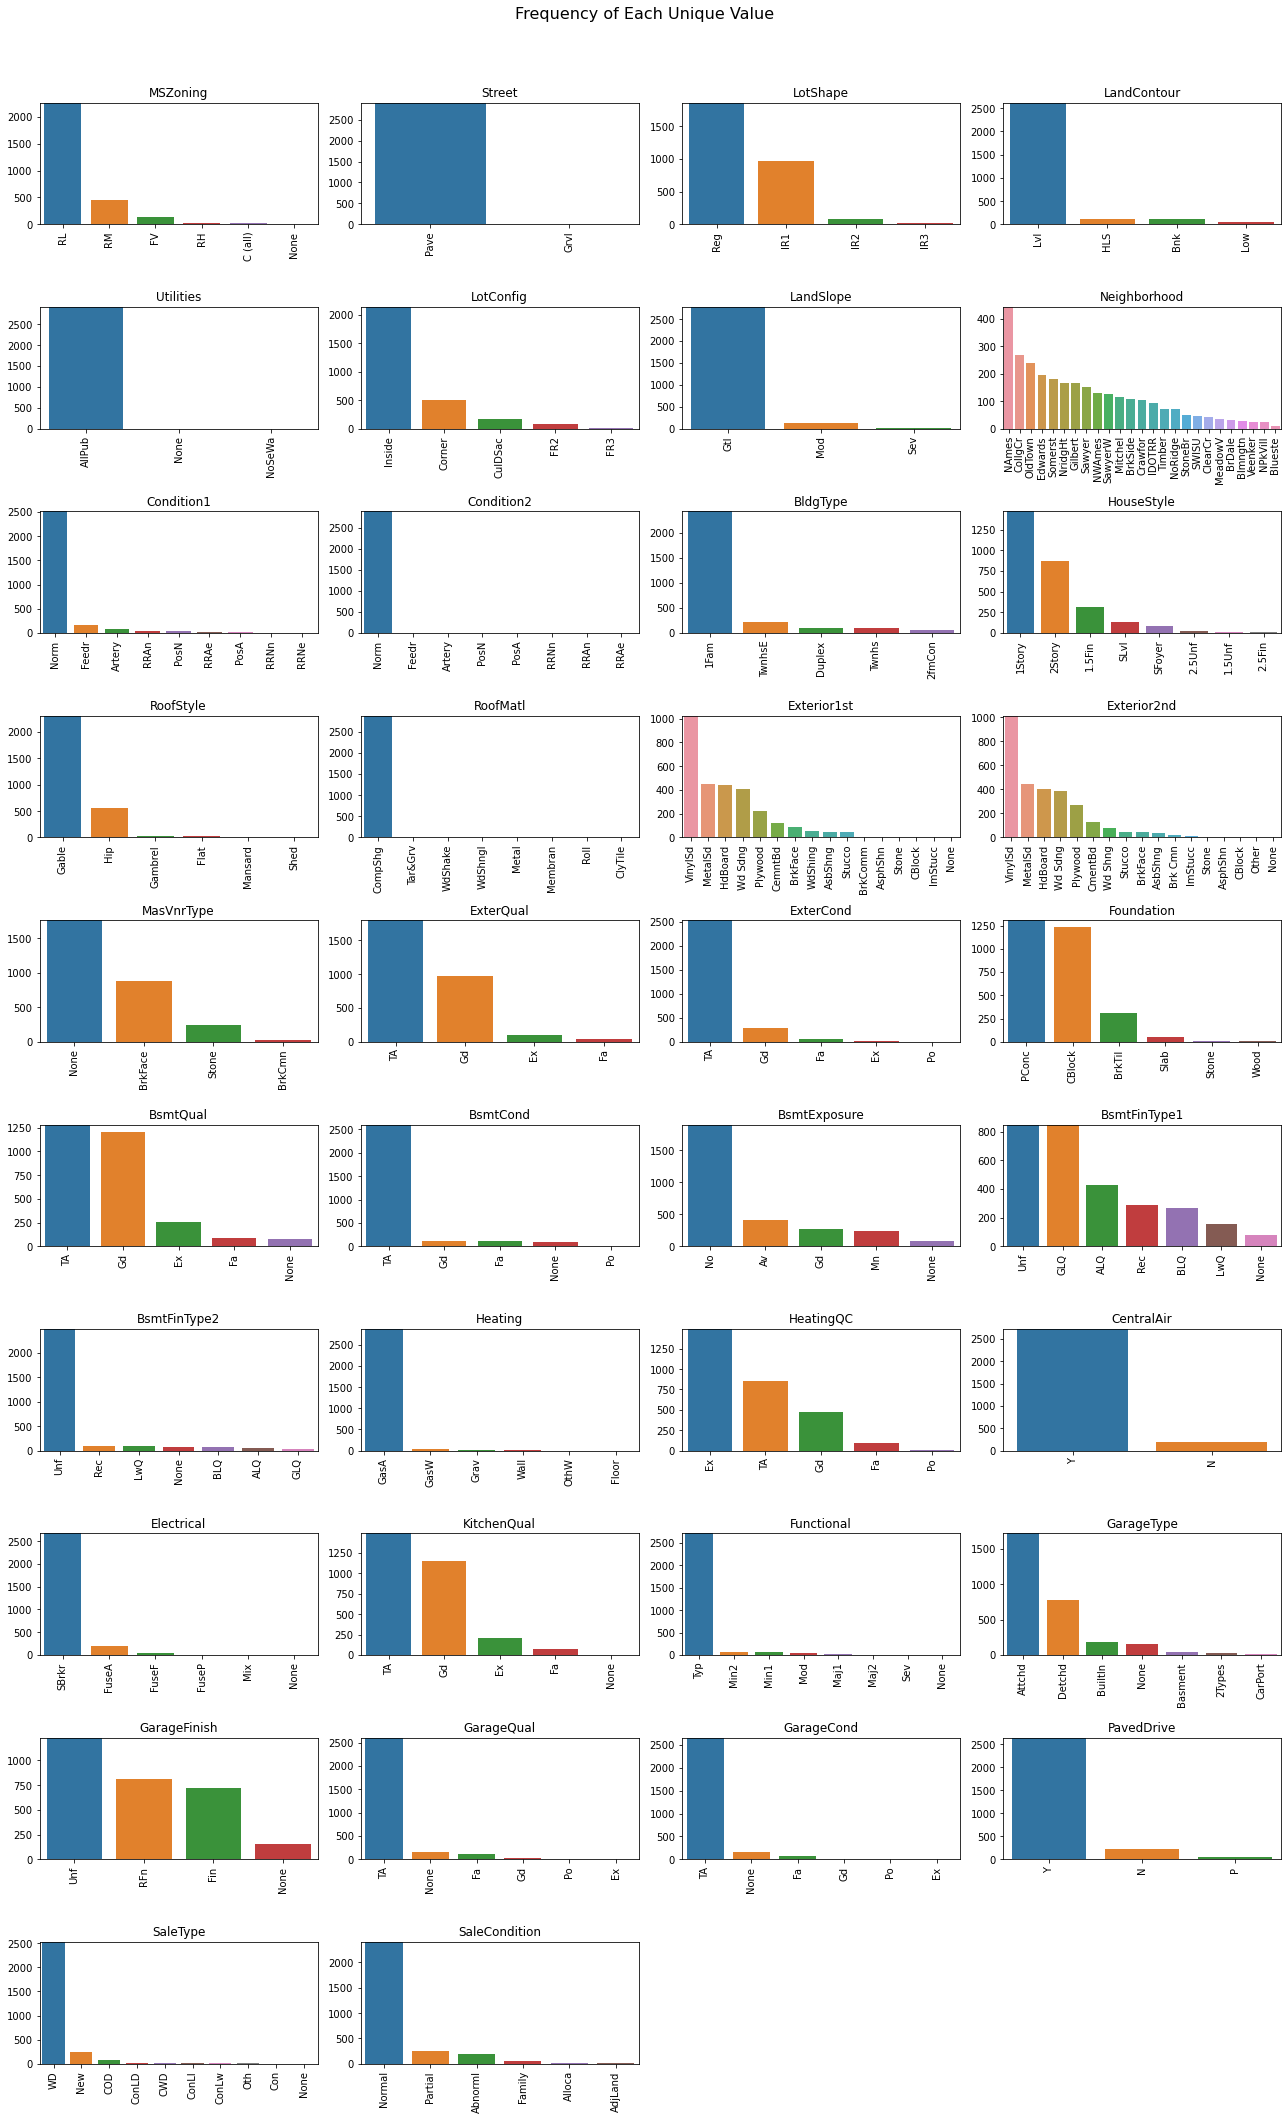

In [321]:
#Plotting the frequency of each unique value
cols = df_combined.select_dtypes(include=['object']).columns 
num_cols = len(cols)
num_rows = (num_cols // 4) + (num_cols % 4 > 0)

plt.figure(figsize=(18, num_rows * 3))  
plt.suptitle('Frequency of Each Unique Value', fontsize=16)

index = 1

for index, col in enumerate(cols, start=1):
    plt.subplot(num_rows, 4, index)
    plt.xticks(rotation=90)
    plt.title(col)

    count = df_combined[col].value_counts()
    
    sns.barplot(x = count.index, y = count.values)
    
    plt.ylim(0, count.max())
    index +=1
    

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

In [322]:
#From the graphs, testihng counts for columns that appear skewed in value distribution
test_cols = ['Utilities', 'Street', 'Condition2', 'RoofMatl', 'GarageCond', 'Functional', 'Heating', 'Electrical']

for col in test_cols:
    print(f"Column {col} values:")
    print(df_combined[col].value_counts())
    print("\n")

Column Utilities values:
AllPub    2916
None         2
NoSeWa       1
Name: Utilities, dtype: int64


Column Street values:
Pave    2907
Grvl      12
Name: Street, dtype: int64


Column Condition2 values:
Norm      2889
Feedr       13
Artery       5
PosN         4
PosA         4
RRNn         2
RRAn         1
RRAe         1
Name: Condition2, dtype: int64


Column RoofMatl values:
CompShg    2876
Tar&Grv      23
WdShake       9
WdShngl       7
Metal         1
Membran       1
Roll          1
ClyTile       1
Name: RoofMatl, dtype: int64


Column GarageCond values:
TA      2654
None     159
Fa        74
Gd        15
Po        14
Ex         3
Name: GarageCond, dtype: int64


Column Functional values:
Typ     2717
Min2      70
Min1      65
Mod       35
Maj1      19
Maj2       9
Sev        2
None       2
Name: Functional, dtype: int64


Column Heating values:
GasA     2874
GasW       27
Grav        9
Wall        6
OthW        2
Floor       1
Name: Heating, dtype: int64


Column Electrical valu

<h6 style="color: #ff5733;">Unique Value & Frequency Findings:</h6>

Based on the graphs and the 4 columns tested above, one value in each column is over represented. Therefore, in the overall regression model, these columns wouldn't make much of a difference. However, a balance must be maintained between simplifying the model while retaining sensitivity to variance

| Column | Action | Logic |
| :--- | :--- | :--- |
| Utilities <br> Street | <span style="color: red;">Remove</span> | Column has no variability and will only introduce noise. |
| Condition2 <br> RoofMtl <br> Functional <br> Heating| <span style="color: red;">Remove</span> | One value is overrepresented, it's important to drop it for model sensitivity |

This approach balances model efficacy and simplicity

In [323]:
#Dropping columns based on data dictionary description and from unique value frequency findings
df_combined = df_combined.drop(columns=test_cols)
df_combined = df_combined.drop(columns=['MiscVal', 'MoSold', 'SaleType', 'SaleCondition'])

<h6 style="color: #ff5733;">Data Dictionary Findings:</h6>

1. **MiscVal:** This feature lacks sufficient description and domain context, making it difficult to interpret or engineer meaningfully. 

2. **MoSold:** We are already considering Year Sold and using Year Built to calculate house age. Month Sold adds minimal additional predictive power and can be omitted.

3. **SaleType:** While it might have some effect on price, it often reflects situational or financial conditions that may not generalize well in prediction models.
4. **SaleCondition:** We're building a model to predict market value, not transaction price, therefore this is not needed 

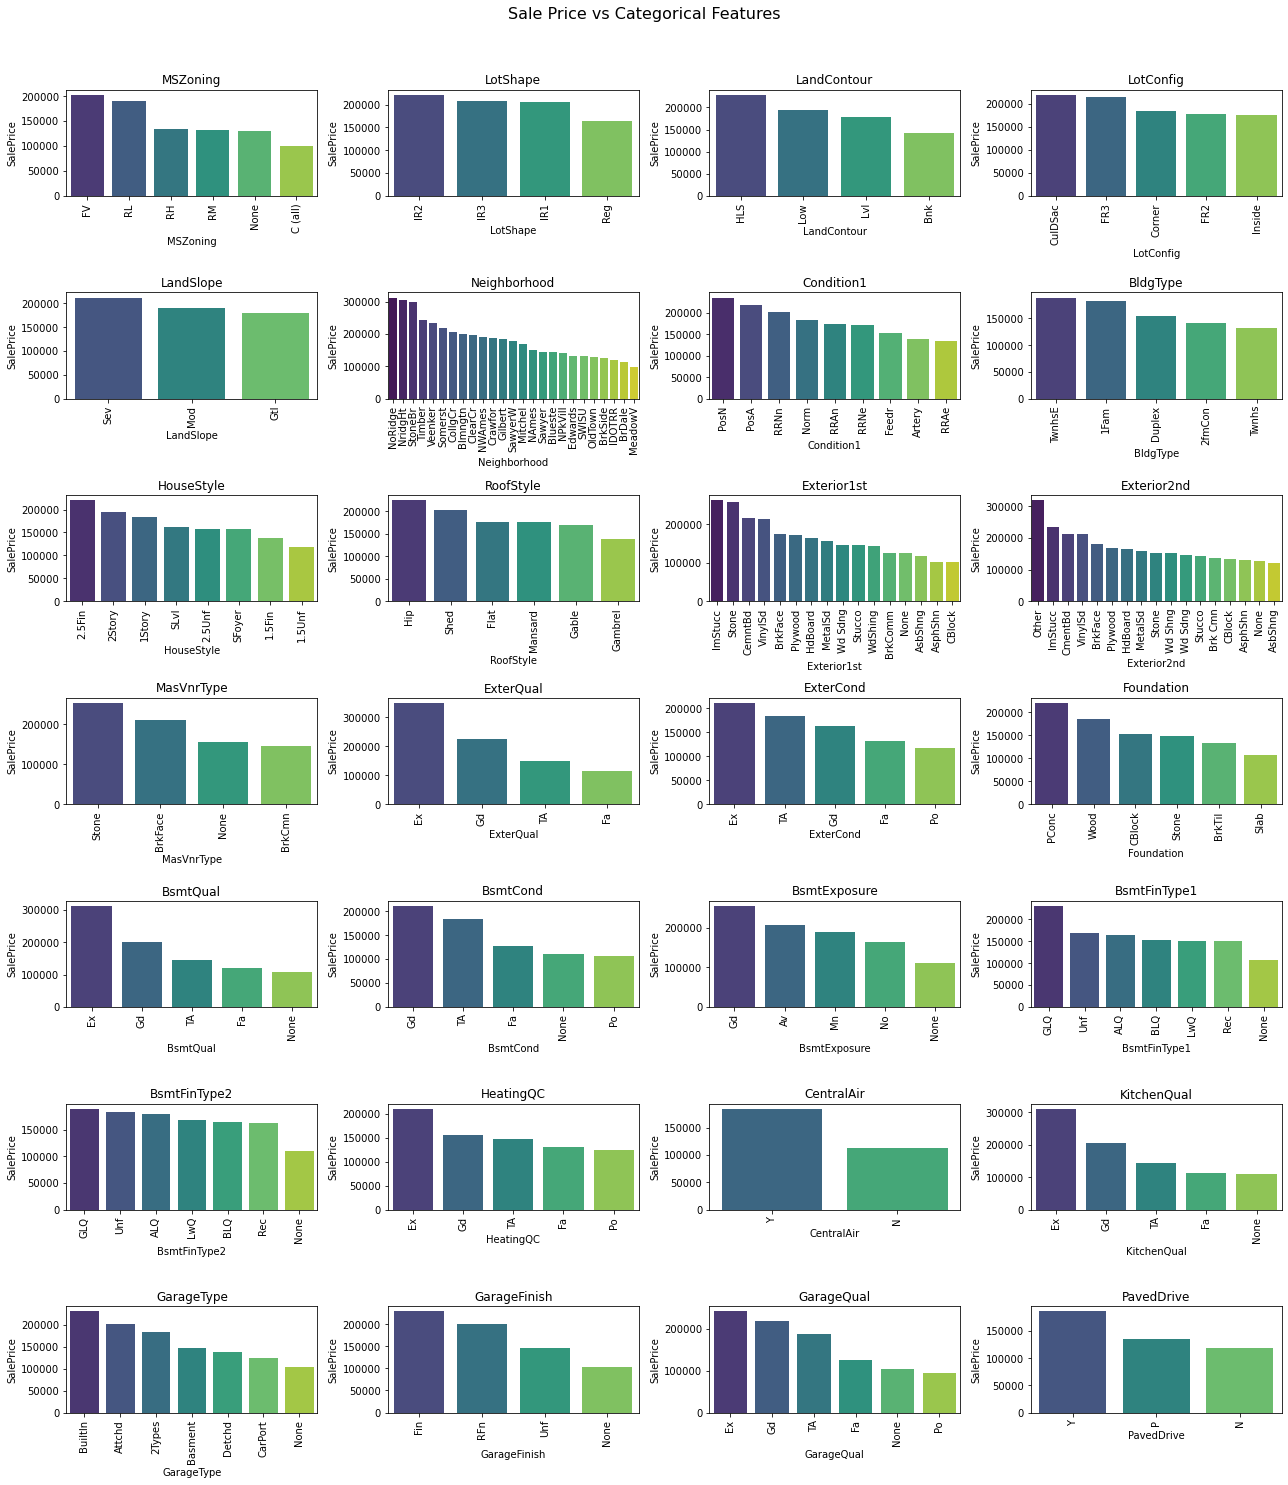

In [324]:
#Plotting the frequency of each unique value
cols = df_combined.select_dtypes(include=['object']).columns 
num_cols = len(cols)
num_rows = (num_cols // 4) + (num_cols % 4 > 0)

plt.figure(figsize=(18, num_rows * 3))  
plt.suptitle('Sale Price vs Categorical Features', fontsize=16)

index = 1

for index, col in enumerate(cols, start=1):
    plt.subplot(num_rows, 4, index)
    plt.xticks(rotation=90)
    plt.title(col)

    avg_price = df_combined.groupby(col)['SalePrice'].mean().sort_values(ascending = False).reset_index()
    
    sns.barplot(x=col, y='SalePrice', data=avg_price, palette='viridis')
    

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

<h6 style="color: #ff5733;">Categorical Data vs Sale Price Findings:</h6>

Based on the graphs the following columns will be dropped due to low variance in Sale Price from the unique values in those columns

1. BsmtFinType2
2. GarageQual
3. Condition1
4. LandSlope
5. RoofStyle
6. LandContour
7. LotConfig
8. BsmtFinType1
9. LotShape
10. ExterCond
11. PavedDrive

This approach balances model efficacy and simplicity

In [325]:
#Dropping columns based on categorical vs sale price analysis
df_combined = df_combined.drop(columns=['GarageQual', 'PavedDrive','ExterCond', 'LotShape', 'BsmtFinType1', 'BsmtFinType2', 'Condition1', 'LandSlope', 'RoofStyle', 'LandContour', 'LotConfig'])

In [326]:
# Correlation matrix for Numeric columns
correlation_matrix = df_combined.select_dtypes(include=['float64', 'int64']).corr()

# Correlation with SalePrice, sorted
print(correlation_matrix['SalePrice'].sort_values(ascending=False))

SalePrice       1.000000
OverallQual     0.690759
GarageCars      0.644772
TotalBsmtSF     0.622052
GarageArea      0.619260
GrLivArea       0.589724
1stFlrSF        0.586112
GarageYrBlt     0.512259
FullBath        0.478118
YearRemodAdd    0.456533
TotRmsAbvGrd    0.422576
BsmtFinSF1      0.407861
Fireplaces      0.396632
LotFrontage     0.360929
WoodDeckSF      0.293752
BsmtFullBath    0.259031
LotArea         0.254646
OpenPorchSF     0.248075
BsmtUnfSF       0.203448
HalfBath        0.202130
2ndFlrSF        0.162657
BedroomAbvGr    0.103631
BsmtFinSF2     -0.006331
Id             -0.025494
LowQualFinSF   -0.027353
BsmtHalfBath   -0.042806
MSSubClass     -0.099869
OverallCond    -0.127460
AgeSold        -0.506591
Name: SalePrice, dtype: float64


In [327]:
#Dropping low correlation columns
corr_target = correlation_matrix['SalePrice']
corr_drop   = correlation_matrix[(corr_target > -0.1) & (corr_target < 0.1)].index.tolist()

if 'Id' in corr_drop:
    corr_drop.remove('Id')

print("Numerical columns dropped:\n")
for col in corr_drop:
    print(col)

# Drop the columns
df_combined = df_combined.drop(columns=corr_drop)

Numerical columns dropped:

MSSubClass
BsmtFinSF2
LowQualFinSF
BsmtHalfBath


In [328]:
print(df_combined.shape)

(2919, 42)


<h6 style="color: #ff5733;">Correlation Findings:</h6>

Housing prices in the dataset are right-skewed and spread widely, ranging from $34,900 to $755,000, with an average around $181K. This wide range reflects the heterogeneity in home size, location, condition, and age.

**Key findings:**

1. OverallQual (0.79) and GrLivArea (0.71) show the strongest positive correlation with sale price.

2. Garage features also matter: GarageCars (0.64) and GarageArea (0.62) boost price.

3. Other moderately important features include TotalBsmtSF, 1stFlrSF, Fireplaces, and FullBath (correlations from 0.45–0.61).

4. These findings match buyer expectations — more space, better finishes, and modern upgrades = higher value.

5. Following columsn have been dropped due to very low correlation with Sale Price (-0.02 < Correlation < 0.02)

- MSSubClass
- OverallCond
- BsmtFinSF2
- LowQualFinSF
- BsmtHalfBath

***Note:*** Categorical variables like Neighborhood, ExterQual, or HouseStyle were not included in the correlation matrix, as they require one-hot encoding. These will be handled during the feature engineering phase.

The EDA step focused on uncovering general patterns, which will inform feature selection and multicollinearity checks during modeling.

### Feature Engineering
1. Dummy variables/One Hot Encoding
2. Test variable significance
3. Collinearity analysis
4. Dimension reduction

In [329]:
categorical_features = df_combined.select_dtypes(include=['object']).columns.tolist()

# Create the ColumnTransformer
column_transformer = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(drop='first', sparse_output=False), categorical_features)
    ],
    remainder='passthrough'  # Keep all non-categorical columns
)

# Apply transformation
df_encoded_array = column_transformer.fit_transform(df_combined)

# Get dummy variable column names
dummy_columns = column_transformer.named_transformers_['cat'].get_feature_names_out(categorical_features)

# Get the non-categorical column names
non_cat_columns = df_combined.drop(columns=categorical_features).columns

# Rebuild the encoded DataFrame
df_model = pd.DataFrame(df_encoded_array, columns=np.append(dummy_columns, non_cat_columns))
df_model.head()

,MSZoning_FV,MSZoning_None,MSZoning_RH,MSZoning_RL,MSZoning_RM,Neighborhood_Blueste,Neighborhood_BrDale,Neighborhood_BrkSide,Neighborhood_ClearCr,Neighborhood_CollgCr,...,BedroomAbvGr,TotRmsAbvGrd,Fireplaces,GarageYrBlt,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,SalePrice,AgeSold
0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,...,3.0,8.0,0.0,2003.0,2.0,548.0,0.0,61.0,208500.0,5.0
1,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,3.0,6.0,1.0,1976.0,2.0,460.0,298.0,0.0,181500.0,31.0
2,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,...,3.0,6.0,1.0,2001.0,2.0,608.0,0.0,42.0,223500.0,7.0
3,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,3.0,7.0,1.0,1998.0,3.0,642.0,0.0,35.0,140000.0,91.0
4,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,4.0,9.0,1.0,2000.0,3.0,836.0,192.0,84.0,250000.0,8.0


This step one-hot encodes all key categorical variables—like neighborhood, house style, and quality ratings—so the model can interpret them numerically, while keeping all other numeric features unchanged.

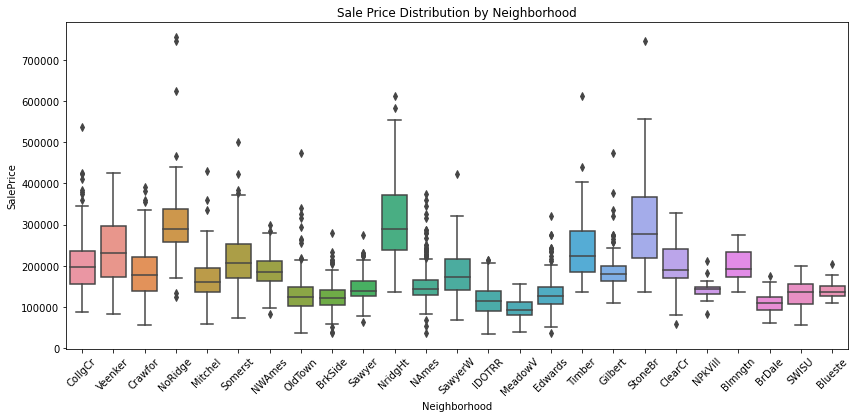

In [330]:
# Boxplot of SalePrice across neighborhoods
plt.figure(figsize=(14, 6))
sns.boxplot(x='Neighborhood', y='SalePrice', data=df_combined)
plt.xticks(rotation=45)
plt.title('Sale Price Distribution by Neighborhood')
plt.show()

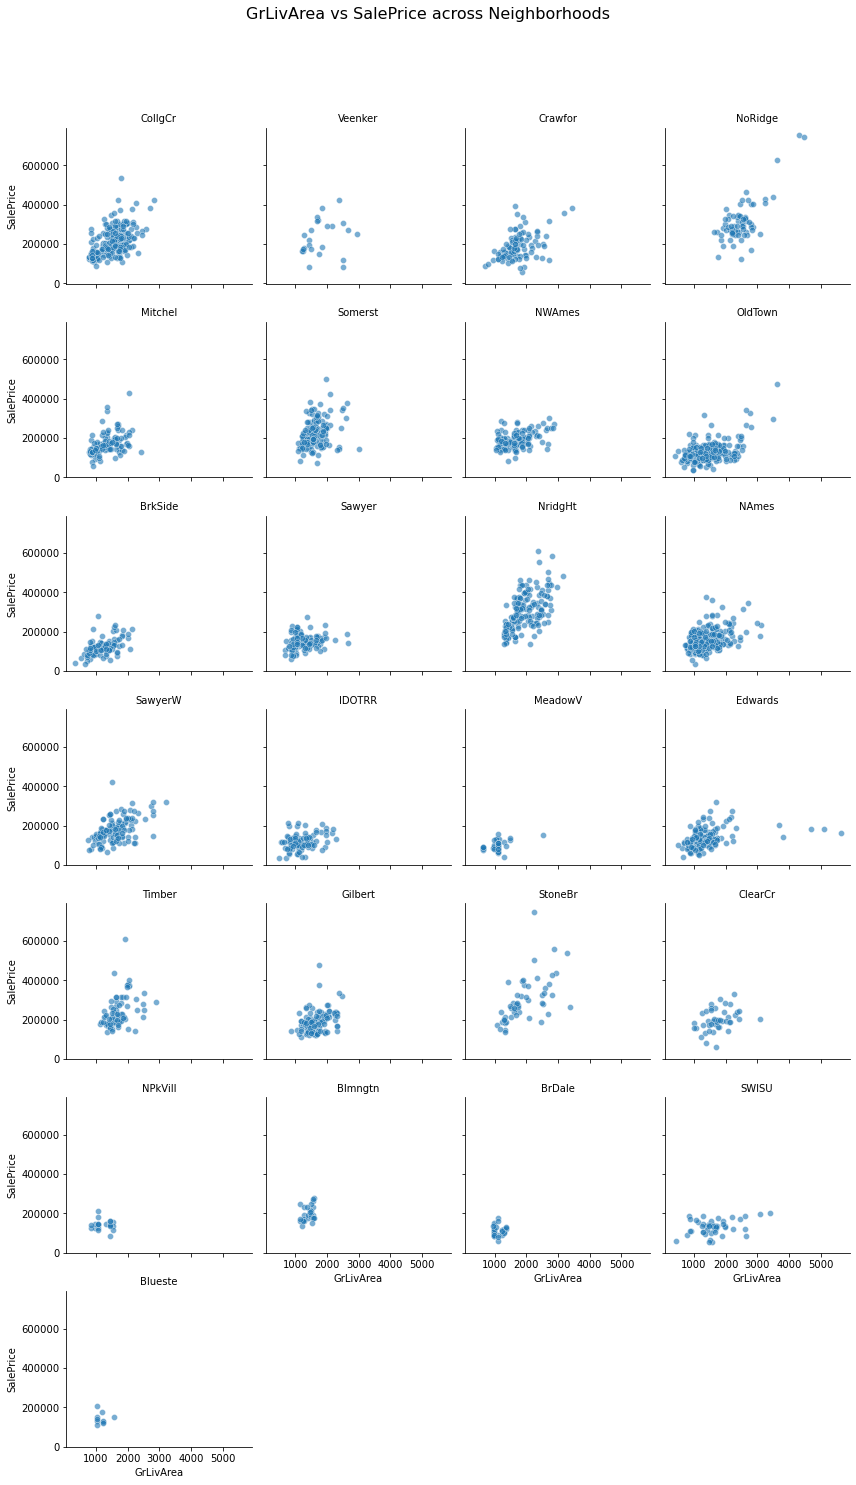

In [331]:
g = sns.FacetGrid(df_combined, col="Neighborhood", col_wrap=4, height=3)
g.map_dataframe(sns.scatterplot, x="GrLivArea", y="SalePrice", alpha=0.6)
g.set_titles(col_template="{col_name}")
g.fig.subplots_adjust(top=0.9)
g.fig.suptitle("GrLivArea vs SalePrice across Neighborhoods", fontsize=16)
plt.show()

In [332]:
# Interaction term between GrLivArea and Neighborhood
model = ols('SalePrice ~ GrLivArea * C(Neighborhood)', data=df_combined).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:              SalePrice   R-squared:                       0.599
Model:                            OLS   Adj. R-squared:                  0.592
Method:                 Least Squares   F-statistic:                     87.41
Date:                Thu, 17 Apr 2025   Prob (F-statistic):               0.00
Time:                        16:23:01   Log-Likelihood:                -35712.
No. Observations:                2919   AIC:                         7.152e+04
Df Residuals:                    2869   BIC:                         7.182e+04
Df Model:                          49                                         
Covariance Type:            nonrobust                                         
                                           coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------


<h6 style="color: #ff5733;">GrLivArea and Neighborhood Findings:</h6>

We explored whether the relationship between GrLivArea (living space) and SalePrice varied across neighborhoods by including interaction terms in a regression model. However, *most of the interaction terms were not statistically significant.*

This suggests **multicollinearity**. In many areas, larger homes tend to cluster in higher-priced neighborhoods, making it difficult for the model to separate the effect of size from the effect of location. As a result, the overlap reduces the precision and usefulness of neighborhood-specific size interactions.

To address this, we looked at housing style breakdowns across neighborhoods and found that size mattered less in uniform, 1-story areas like OldTown and IDOTRR. In contrast, price moved more with size in neighborhoods like NoRidge and StoneBr, which include more varied and custom homes.

This insight led us to introduce a HousingTypeGroup feature — a new classification that captures structural differences (like layout and lot size) across the city. While this reduces neighborhood-level granularity, it adds important context about how much physical space matters, and complements broader location trends already captured by NeighborhoodTier.

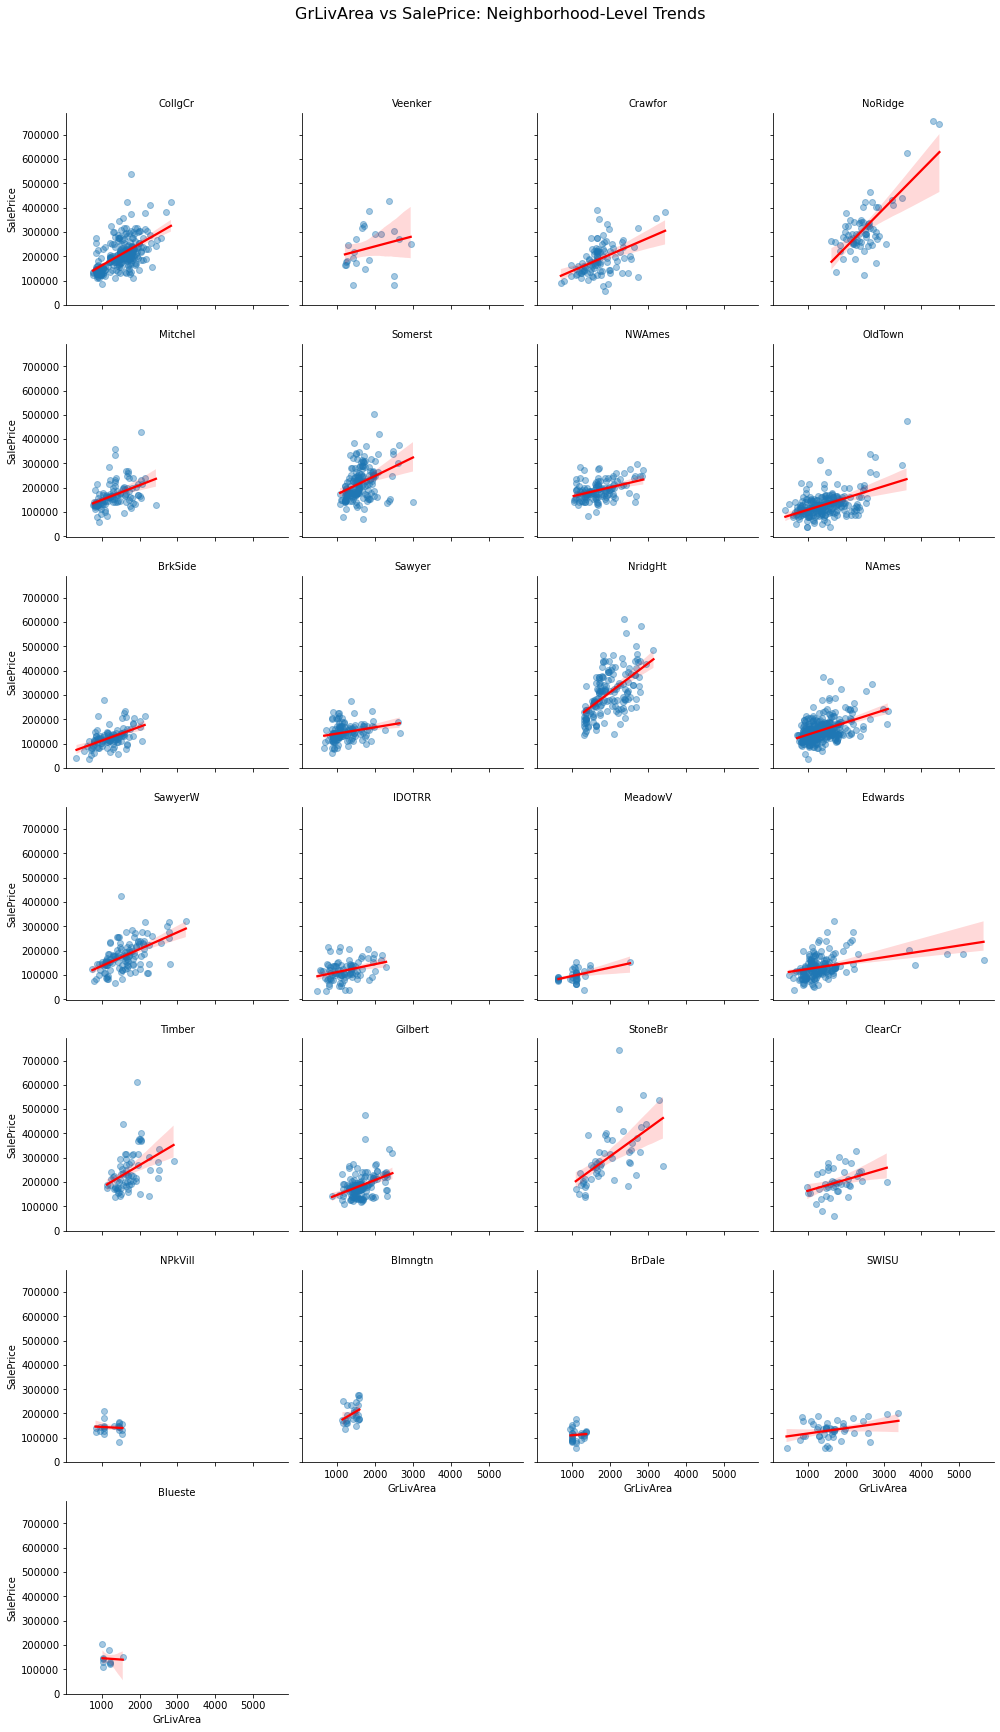

In [333]:
# Plot GrLivArea vs SalePrice, by neighborhood
g = sns.lmplot(
    data=df_combined,
    x="GrLivArea",
    y="SalePrice",
    col="Neighborhood",
    col_wrap=4,
    height=3.5,
    scatter_kws={'alpha':0.4},
    line_kws={'color': 'red'}
)

g.set_titles(col_template="{col_name}")
g.fig.subplots_adjust(top=0.92)
g.fig.suptitle("GrLivArea vs SalePrice: Neighborhood-Level Trends", fontsize=16)
plt.show()

This approach:
-Uses all data (no subsetting)
-Avoids overfitting (no bloated interaction model)
-Clearly shows how size impacts price across locations
What we found:
-Some neighborhoods (e.g., NoRidge, StoneBr) show steeper slopes — price increases sharply with size.
- Others (e.g., OldTown, IDOTRR) show flatter slopes — size has less influence.

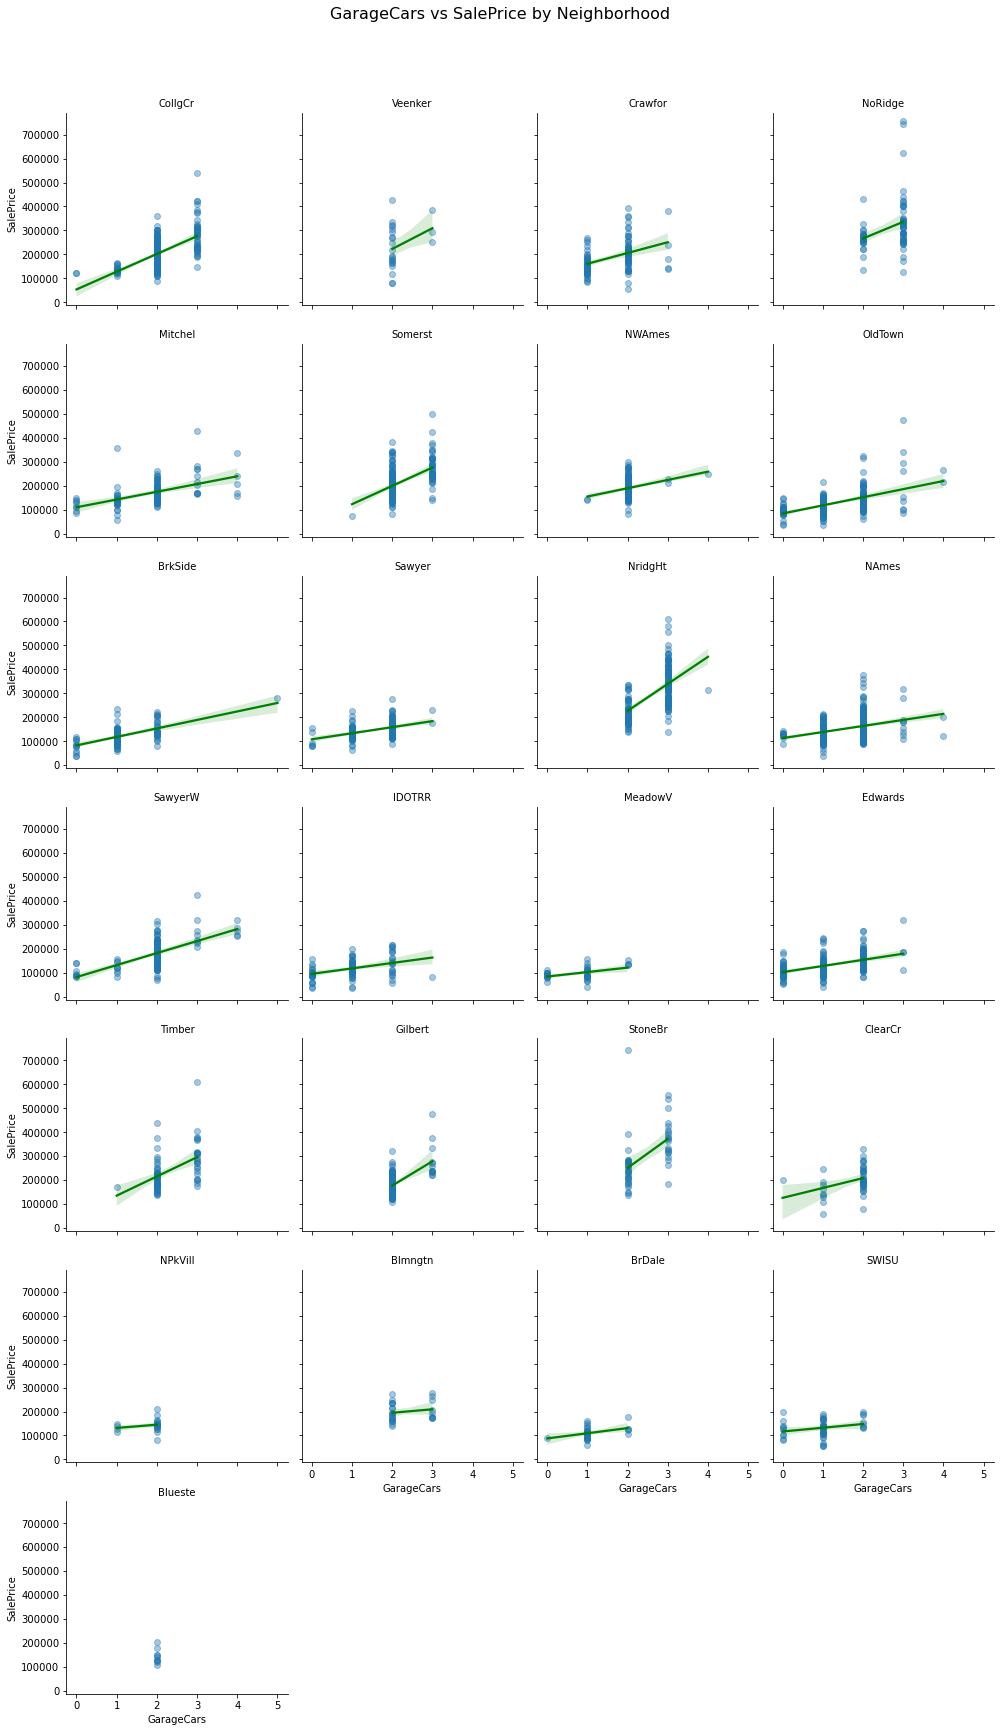

In [334]:
g = sns.lmplot(
    data=df_combined,
    x="GarageCars",
    y="SalePrice",
    col="Neighborhood",
    col_wrap=4,
    height=3.5,
    scatter_kws={'alpha':0.4},
    line_kws={'color': 'green'}
)
g.set_titles(col_template="{col_name}")
g.fig.subplots_adjust(top=0.92)
g.fig.suptitle("GarageCars vs SalePrice by Neighborhood", fontsize=16)
plt.show()

We examined how garage size and type vary by neighborhood. Higher-income areas like NoRidge and StoneBr tend to have larger garages, while neighborhoods like OldTown or IDOTRR show smaller, less finished garages.
Facet plots suggest that the price premium for garage area is stronger in upscale neighborhoods, while having less impact in others — highlighting another location-specific feature interaction.

In [335]:
# Model with main effects only
model_top = ols('SalePrice ~ OverallQual + GrLivArea + C(Neighborhood)', data=df_combined).fit()
model_top.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              SalePrice   R-squared:                       0.603
Model:                            OLS   Adj. R-squared:                  0.599
Method:                 Least Squares   F-statistic:                     169.0
Date:                Thu, 17 Apr 2025   Prob (F-statistic):               0.00
Time:                        16:23:17   Log-Likelihood:                -35697.
No. Observations:                2919   AIC:                         7.145e+04
Df Residuals:                    2892   BIC:                         7.161e+04
Df Model:                          26                                         
Covariance Type:            nonrobust                                         
==============================================================================================
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
Intercept                   1.311e+04   1.17e+04      1.124      0.261   -9765.313     3.6e+04
C(Neighborhood)[T.Blueste] -3.564e+04   1.83e+04     -1.943      0.052   -7.16e+04     325.605
C(Neighborhood)[T.BrDale]  -5.003e+04   1.31e+04     -3.806      0.000   -7.58e+04   -2.43e+04
C(Neighborhood)[T.BrkSide] -3.139e+04   1.07e+04     -2.921      0.004   -5.25e+04   -1.03e+04
C(Neighborhood)[T.ClearCr]  4507.9625   1.22e+04      0.371      0.711   -1.93e+04    2.83e+04
C(Neighborhood)[T.CollgCr]  1.144e+04   9903.987      1.155      0.248   -7980.767    3.09e+04
C(Neighborhood)[T.Crawfor] -8544.0627   1.07e+04     -0.798      0.425   -2.95e+04    1.24e+04
C(Neighborhood)[T.Edwards] -2.701e+04   1.03e+04     -2.624      0.009   -4.72e+04   -6821.912
C(Neighborhood)[T.Gilbert] -1.263e+04   1.02e+04     -1.235      0.217   -3.27e+04    7413.522
C(Neighborhood)[T.IDOTRR]  -3.002e+04    1.1e+04     -2.730      0.006   -5.16e+04   -8458.139
C(Neighborhood)[T.MeadowV] -3.791e+04   1.28e+04     -2.972      0.003   -6.29e+04   -1.29e+04
C(Neighborhood)[T.Mitchel]  2022.5594   1.06e+04      0.190      0.849   -1.88e+04    2.29e+04
C(Neighborhood)[T.NAmes]   -1.162e+04   9869.788     -1.177      0.239    -3.1e+04    7734.311
C(Neighborhood)[T.NPkVill] -3.431e+04    1.4e+04     -2.446      0.015   -6.18e+04   -6805.798
C(Neighborhood)[T.NWAmes]  -7153.1220   1.04e+04     -0.685      0.493   -2.76e+04    1.33e+04
C(Neighborhood)[T.NoRidge]  5.377e+04   1.13e+04      4.740      0.000    3.15e+04     7.6e+04
C(Neighborhood)[T.NridgHt]  6.228e+04   1.03e+04      6.075      0.000    4.22e+04    8.24e+04
C(Neighborhood)[T.OldTown] -3.614e+04   1.02e+04     -3.557      0.000   -5.61e+04   -1.62e+04
C(Neighborhood)[T.SWISU]    -4.77e+04    1.2e+04     -3.967      0.000   -7.13e+04   -2.41e+04
C(Neighborhood)[T.Sawyer]  -7699.6639   1.04e+04     -0.737      0.461   -2.82e+04    1.28e+04
C(Neighborhood)[T.SawyerW] -1.499e+04   1.05e+04     -1.432      0.152   -3.55e+04    5535.708
C(Neighborhood)[T.Somerst]  6094.1921   1.01e+04      0.603      0.547   -1.37e+04    2.59e+04
C(Neighborhood)[T.StoneBr]  5.619e+04   1.18e+04      4.768      0.000    3.31e+04    7.93e+04
C(Neighborhood)[T.Timber]   2.962e+04   1.11e+04      2.667      0.008    7844.736    5.14e+04
C(Neighborhood)[T.Veenker]  1.511e+04   1.39e+04      1.089      0.276   -1.21e+04    4.23e+04
OverallQual                 1.766e+04   1075.948     16.416      0.000    1.56e+04    1.98e+04
GrLivArea                     42.8685      2.387     17.956      0.000      38.187      47.550
==============================================================================
Omnibus:                      878.005   Durbin-Watson:                   1.930
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             6703.

We built a model combining OverallQual, GrLivArea, and Neighborhood, as these are the top drivers of housing price.
All three variables were strong, independent predictors:

-	OverallQual captured finish and condition
-	GrLivArea measured usable space
-	Neighborhood reflected location-based pricing

This model uses clean, interpretable variables and avoids overfitting while capturing most of the variation in housing prices.

In [336]:
##VIF
# Define formula using key numerical and categorical predictors
vif_formula = 'SalePrice ~ GrLivArea + OverallQual + GarageCars + Fireplaces'

# Create design matrices (y = target, X = predictors)
y, X = dmatrices(vif_formula, data=df_combined, return_type='dataframe')

# Calculate VIF for each column in the predictor matrix
vif_data = pd.DataFrame({
    'Variable': X.columns,
    'VIF': [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
})

# Display the result
print(vif_data)

      Variable        VIF
0    Intercept  21.324559
1    GrLivArea   1.720533
2  OverallQual   1.901331
3   GarageCars   1.649182
4   Fireplaces   1.310817


<h6 style="color: #ff5733;">Collinearity Findings:</h6>

All predictors showed low VIF scores (under 3), meaning no multicollinearity issues. Our variables are stable, and the model results can be trusted.

we paired condition variables with structural and quality factors (e.g., OverallQual, GrLivArea) to isolate how external surroundings influence price independent of general location. This allows us to evaluate whether certain positive (e.g., near parks) or negative (e.g., near railroad) conditions impact value when home quality is held constant.

### Re-assessing and Removing outliers

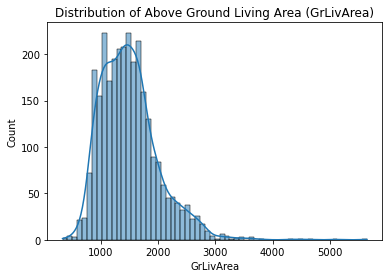

In [337]:
#Plotting distribution of living area
sns.histplot(df_combined['GrLivArea'], kde=True)
plt.title("Distribution of Above Ground Living Area (GrLivArea)")
plt.show()

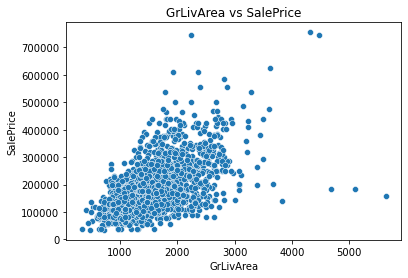

In [338]:
sns.scatterplot(x='GrLivArea', y='SalePrice', data=df_combined)
plt.title("GrLivArea vs SalePrice")
plt.show()

/Users/rabab/opt/anaconda3/lib/python3.9/site-packages/seaborn/axisgrid.py:337: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


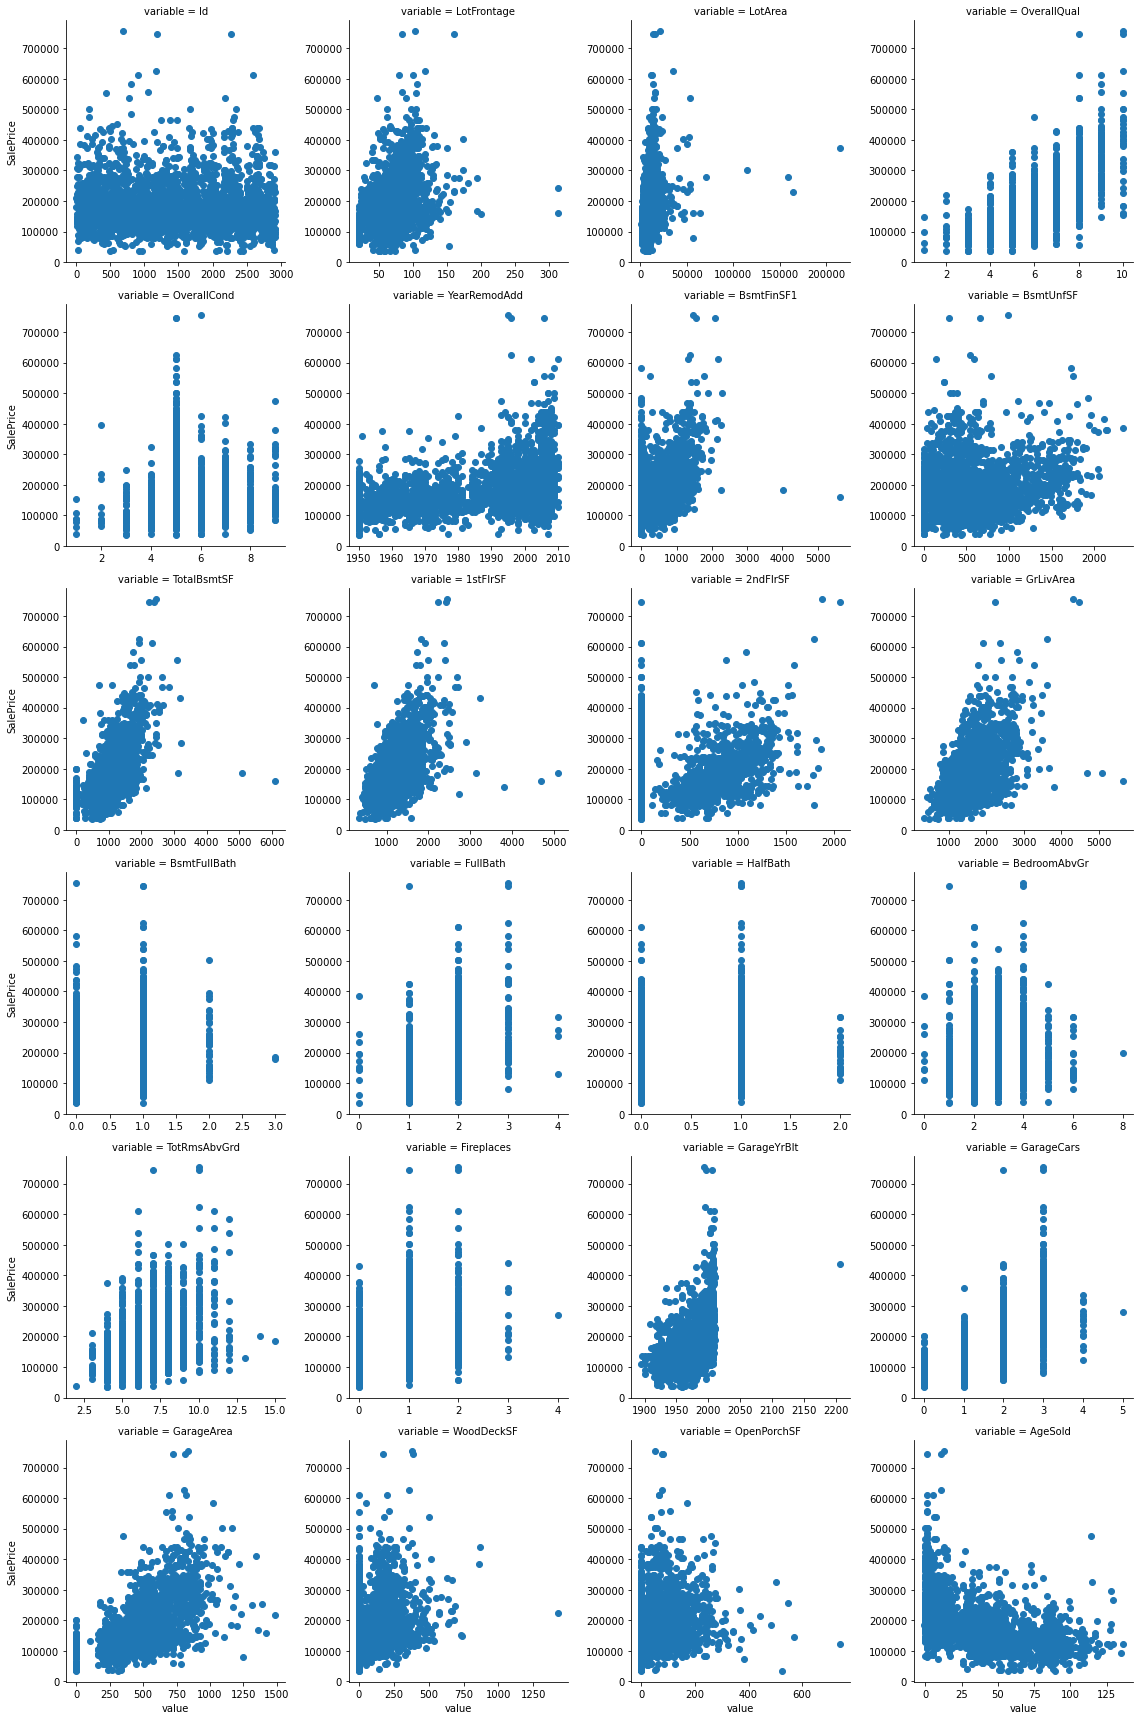

In [339]:
tr = df_combined[df_combined["SalePrice"].isnull() == False]
y = tr["SalePrice"]
tr = tr.select_dtypes(include=['float64', "int64"])
tr.drop("SalePrice", axis=1, inplace=True)

f = pd.melt(pd.concat([tr,y],axis=1) , id_vars = ['SalePrice'] , value_vars = tr.columns )
g = sns.FacetGrid(f, col = 'variable' , col_wrap = 4, size = 4,sharex=False , sharey=False)
g = g.map(plt.scatter, "value", "SalePrice")

In [340]:
df_combined[['GrLivArea', 'SalePrice']].corr()

,GrLivArea,SalePrice
GrLivArea,1.000000,0.589724
SalePrice,0.589724,1.000000


GrLivArea shows a strong positive correlation (0.71) with SalePrice.


In [341]:
df_combined = df_combined.drop(df_combined[(df_combined["GrLivArea"] > 4000) & (df_combined['SalePrice'] < 300000)].index)
df_combined = df_combined.drop(df_combined[(df_combined['TotalBsmtSF'] > 5000) & (df_combined['SalePrice'] < 300000)].index)
df_combined = df_combined.drop(df_combined[(df_combined['BsmtFinSF1'] > 4000) & (df_combined['SalePrice'] < 300000)].index)
df_combined = df_combined.drop(df_combined[(df_combined['LotFrontage'] > 250) & (df_combined['SalePrice'] < 300000)].index)
df_combined = df_combined.drop(df_combined[(df_combined['OpenPorchSF'] > 400) & (df_combined['SalePrice'] < 100000)].index)
df_combined = df_combined.drop(df_combined[(df_combined['1stFlrSF'] > 4000) & (df_combined['SalePrice'] < 200000)].index)

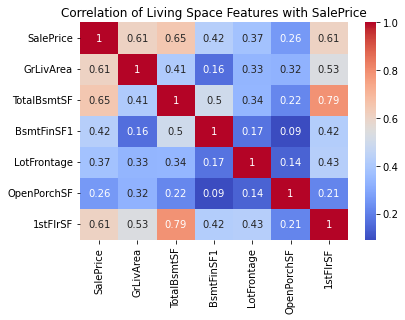

In [342]:
sns.heatmap(df_combined[['SalePrice', 'GrLivArea', 'TotalBsmtSF', 'BsmtFinSF1','LotFrontage', 'OpenPorchSF','1stFlrSF' ]].corr(), annot=True, cmap='coolwarm')
plt.title("Correlation of Living Space Features with SalePrice")
plt.show()

In [343]:
def layout_tag(row):
    if row['TotRmsAbvGrd'] >= 9:
        return 'Many Rooms'
    elif row['TotRmsAbvGrd'] <= 5:
        return 'Few Rooms'
    else:
        return 'Typical Layout'

df_combined['LayoutType'] = df_combined.apply(layout_tag, axis=1)

We added `AvgRoomSize`, `TotalBaths`, and `LayoutType` to reflect how space is experienced, not just measured.


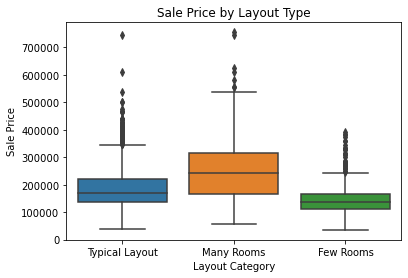

In [344]:
sns.boxplot(x='LayoutType', y='SalePrice', data=df_combined)
plt.title('Sale Price by Layout Type')
plt.xlabel('Layout Category')
plt.ylabel('Sale Price')
plt.show()

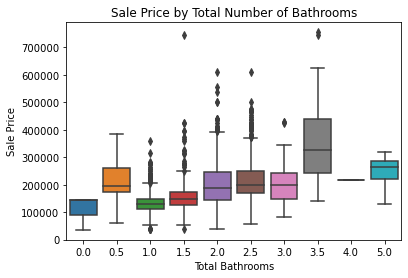

In [345]:
df_combined['TotalBaths'] = df_combined['FullBath'] + 0.5 * df_combined['HalfBath']

#Dropping Full Bath and Half Bath because those are included in Total Baths columns
df_combined = df_combined.drop(columns = ['FullBath', 'HalfBath'])

sns.boxplot(x='TotalBaths', y='SalePrice', data=df_combined)
plt.title("Sale Price by Total Number of Bathrooms")
plt.xlabel("Total Bathrooms")
plt.ylabel("Sale Price")
plt.show()

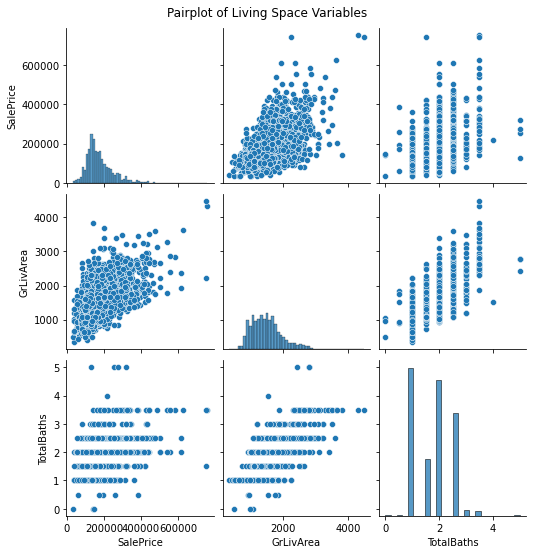

In [346]:
living_features = ['SalePrice', 'GrLivArea', 'TotalBaths']

sns.pairplot(df_combined[living_features].dropna())
plt.suptitle("Pairplot of Living Space Variables", y=1.02)
plt.show()

- `GrLivArea` and `TotalSqFt` both show strong positive linear relationships with `SalePrice`.
- `LivingAreaPerRoom` and `AvgRoomSize` have more scattered relationships, indicating layout efficiency may play a secondary role compared to overall size.
- `TotalBaths` shows a mild positive correlation with `SalePrice` but some variation, especially in homes with more than 3 baths.
- `TotalSqFt` and `GrLivArea` are highly collinear, which is expected since they are structurally related.

This plot supports the idea that engineered features like `TotalSqFt` and `TotalBaths` contribute valuable signals to price prediction, while `AvgRoomSize` and `LivingAreaPerRoom` provide additional nuance about usability of space.

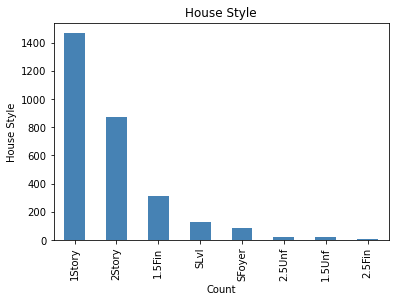

In [347]:
ax = df_combined['HouseStyle'].value_counts()\
.plot(kind='bar', color='steelblue', title='House Style') 
ax.set_xlabel('Count')
ax.set_ylabel('House Style')
plt.show()

In [348]:
# Filter column names containing "SF" or "sf1"
sf_columns = [col for col in df_combined.columns if "SF" in col or "SF1" in col]
print(sf_columns)
df_SQFT = df_combined[sf_columns].copy()

['BsmtFinSF1', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'WoodDeckSF', 'OpenPorchSF']


In [349]:
# Group by 'HouseStyle' and calculate some aggregate statistics
house_style_group = df_combined.groupby('HouseStyle').size()

# Display the result
print("Grouped by HouseStyle:")
print(house_style_group)

Grouped by HouseStyle:
HouseStyle
1.5Fin     314
1.5Unf      19
1Story    1468
2.5Fin       8
2.5Unf      24
2Story     870
SFoyer      83
SLvl       128
dtype: int64


In [350]:
# Find columns containing "Qual"
qual_columns = [col for col in df_combined.columns if "Qual" in col]

# Display the result
print("Columns containing 'Qual':")
print(qual_columns)

Columns containing 'Qual':
['OverallQual', 'ExterQual', 'BsmtQual', 'KitchenQual']


In [351]:
df_qual = df_combined[qual_columns]
df_qual.head(10)

,OverallQual,ExterQual,BsmtQual,KitchenQual
0,7,Gd,Gd,Gd
1,6,TA,Gd,TA
2,7,Gd,Gd,Gd
3,7,TA,TA,Gd
4,8,Gd,Gd,Gd
5,5,TA,Gd,TA
6,8,Gd,Ex,Gd
7,7,TA,Gd,TA
8,7,TA,TA,TA
9,5,TA,TA,TA


In [352]:
# If df_qual contains categorical columns, encode them into numeric values
df_qual_encoded = df_qual.apply(lambda col: col.astype('category').cat.codes if col.dtypes == 'object' else col)

# Compute the correlation between df_qual columns and SalePrice
correlation_with_saleprice = df_qual_encoded.corrwith(df_combined['SalePrice'])

# Display the correlation values
print("Correlation between df_qual columns and SalePrice:")
print(correlation_with_saleprice)

Correlation between df_qual columns and SalePrice:
OverallQual    0.693325
ExterQual     -0.577371
BsmtQual      -0.542154
KitchenQual   -0.523853
dtype: float64


In [353]:
total_sqft_columns = ['TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'GrLivArea']
df_combined['Total_sqft'] = df_combined[total_sqft_columns].sum(axis=1)
df_total_sqft = df_combined[total_sqft_columns].copy()
df_combined['Total_sqft'].head(10)

0    4276.0
1    3786.0
2    4492.0
3    4190.0
4    5541.0
5    3520.0
6    5074.0
7    5287.0
8    4500.0
9    3145.0
Name: Total_sqft, dtype: float64

In [354]:
# If df_qual contains categorical columns, encode them into numeric values
df_qual_encoded = df_qual.apply(lambda col: col.astype('category').cat.codes if col.dtypes == 'object' else col)

# Compute the correlation between Total_sqft and each column in df_qual
correlation_with_total_sqft = df_qual_encoded.corrwith(df_combined['Total_sqft'])

# Display the correlation values
print("Correlation between Total_sqft and df_qual columns:")
print(correlation_with_total_sqft)

Correlation between Total_sqft and df_qual columns:
OverallQual    0.655498
ExterQual     -0.465798
BsmtQual      -0.416166
KitchenQual   -0.451382
dtype: float64


#### Technique 3: Feature Engineering – Living Space  


##### Goal  
To understand how different dimensions of living space influence housing prices and improve the predictive power of our regression model.

---

##### Variables Explored  
- `GrLivArea` – Above-ground living area (main driver)  
- `TotalSqFt` – GrLivArea + TotalBsmtSF  
- `LivingAreaPerRoom` – Efficiency of space use  
- `TotalBsmtFinished` – Combined finished basement  
- `Has_Basement` – Dummy variable: 1 if basement exists  
- `SecondVsFirst` – Ratio of second floor to first floor size  

---

##### Data Cleaning & Engineering  
- Outliers in `GrLivArea` removed (> 4000 sqft)  
- Inf/nan values handled in engineered features  
- All variables checked for multicollinearity using VIF  

---

##### Visual Evidence  
1. GrLivArea Distribution: Right-skewed, mostly clustered between 1000–2500 sqft  
2. Scatterplot GrLivArea vs SalePrice: Strong positive linear trend  
3. Correlation Heatmap:  
   - `TotalSqFt` has highest correlation with SalePrice: 0.82  
   - `GrLivArea`: 0.72  
   - `LivingAreaPerRoom`: 0.53  

---

##### Model Evaluation  

###### Simple Model  
`ols('SalePrice ~ GrLivArea')`  
R² = 0.519 | Adj. R² = 0.519

###### Log Model  
`ols('Log_SalePrice ~ Log_GrLivArea')`  
R² = 0.537 | Adj. R² = 0.537

###### Extended Model (All Living Space Features)  
`ols('SalePrice ~ GrLivArea + TotalSqFt + LivingAreaPerRoom + Has_Basement + TotalBsmtFinished + SecondVsFirst')`  
R² = 0.699 | Adj. R² = 0.698

---

##### VIF Results  
| Feature             | VIF   |
|---------------------|--------|
| GrLivArea           | 14.61  |
| TotalSqFt           | 12.50  |
| LivingAreaPerRoom   | 1.72   |
| Has_Basement        | 1.52   |
| TotalBsmtFinished   | 1.35   |
| SecondVsFirst       | 3.19   |

Note: GrLivArea and TotalSqFt have high collinearity. One may need to be dropped in the final model.

---

##### Residual Plot  
- No major heteroskedasticity observed  
- Slight funnel shape suggests minor variance issues at higher prices  

---

##### Summary  
The analysis confirms that living space significantly impacts housing prices, with `TotalSqFt` being the strongest individual predictor.  
New engineered variables like `LivingAreaPerRoom` and `SecondVsFirst` enhance model interpretability.  
A combined model using all features increases adjusted R² from 0.519 to 0.698, showing strong added value.  
Next steps include refining variable selection and testing robustness in final model comparison.
ining variable selection and testing robustness in final model comparison.
ining variable selection and testing robustness in final model comparison.


### Predictive Modelling
1. Multiple Lineaer Regression
2. Heteroskedascity analysis
3. Hypothesis Testing
4. MAE and RMSE analysis

In [355]:
df_combined.head()

,Id,MSZoning,LotFrontage,LotArea,Neighborhood,BldgType,HouseStyle,OverallQual,OverallCond,YearRemodAdd,...,GarageFinish,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,SalePrice,AgeSold,LayoutType,TotalBaths,Total_sqft
0,1,RL,65.0,8450,CollgCr,1Fam,2Story,7,5,2003,...,RFn,2.0,548.0,0,61,208500.0,5,Typical Layout,2.5,4276.0
1,2,RL,80.0,9600,Veenker,1Fam,1Story,6,8,1976,...,RFn,2.0,460.0,298,0,181500.0,31,Typical Layout,2.0,3786.0
2,3,RL,68.0,11250,CollgCr,1Fam,2Story,7,5,2002,...,RFn,2.0,608.0,0,42,223500.0,7,Typical Layout,2.5,4492.0
3,4,RL,60.0,9550,Crawfor,1Fam,2Story,7,5,1970,...,Unf,3.0,642.0,0,35,140000.0,91,Typical Layout,1.0,4190.0
4,5,RL,84.0,14260,NoRidge,1Fam,2Story,8,5,2000,...,RFn,3.0,836.0,192,84,250000.0,8,Many Rooms,2.5,5541.0


In [356]:
print(f"df_combined: {df_combined.shape}")

df_combined: (2914, 43)


In [357]:
#df_combined = pd.get_dummies(df_combined.drop(columns = ['Id']), drop_first = True)
df_combined = pd.get_dummies(df_combined, drop_first = True)

In [358]:
# df_train = df_combined[df_combined['SalePrice'].notna()].copy()
# df_test  = df_combined[df_combined['SalePrice'].isna()].copy()
df_train = df_combined[df_combined['Id'] <= 1460].copy()
df_test  = df_combined[df_combined['Id'] > 1460].copy()

In [359]:
# Target and features
#y = np.log1p(df_combined["SalePrice"])
# y = df_combined['SalePrice']
# X = df_combined.drop(columns=["SalePrice"])
# X = pd.get_dummies(X, drop_first=True)

# #Split data
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=42)

In [360]:
X_train = df_train.drop(columns=["SalePrice"])
y       = df_train['SalePrice']
X_test  = df_train.drop(columns=["SalePrice"])

In [361]:
# Fit linear lasso regression model
lasso = Lasso(alpha=1.0)
lasso.fit(X_train, y)

/Users/rabab/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.591e+11, tolerance: 9.182e+08
  model = cd_fast.enet_coordinate_descent(


Lasso()

In [369]:
print(len(df_test))


df_test.to_csv('submission.csv', index = False)

1458


In [362]:
y_pred = lasso.predict(X_test)

In [364]:
print(f"Length of test_ids: {len(test_ids)}")
print(f"Length of y_pred: {len(y_pred)}")


Length of test_ids: 1458
Length of y_pred: 1456


In [363]:
test_ids = df_test['Id']

submission = pd.DataFrame({
    'Id'        : test_ids.values,
    'SalePrice' : y_pred
})

submission.to_csv('submission.csv', index = False)

ValueError: All arrays must be of the same length

In [58]:
#Build the model equation
equation = ""
for coef, feat in zip(reg.coef_, X_train):
    equation += f"({coef:.3f} x {feat}) + \n"

print(f"""The linear regression model is:  \n
    Sales Price = {equation}({reg.intercept_:3f})""")

The linear regression model is:  

    Sales Price = (-10.092 x LotFrontage) + 
(0.496 x LotArea) + 
(7868.034 x OverallQual) + 
(198.205 x YearRemodAdd) + 
(15.248 x BsmtFinSF1) + 
(-6.791 x BsmtUnfSF) + 
(10.737 x TotalBsmtSF) + 
(-16.327 x 1stFlrSF) + 
(12.804 x 2ndFlrSF) + 
(15.132 x GrLivArea) + 
(-2176.419 x BsmtFullBath) + 
(-7894.303 x BedroomAbvGr) + 
(1763.421 x TotRmsAbvGrd) + 
(1686.126 x Fireplaces) + 
(21.434 x GarageYrBlt) + 
(7196.287 x GarageCars) + 
(3.812 x GarageArea) + 
(10.480 x WoodDeckSF) + 
(40.428 x OpenPorchSF) + 
(-213.852 x AgeSold) + 
(-94.562 x TotalBaths) + 
(22.347 x Total_sqft) + 
(47595.813 x MSZoning_FV) + 
(33599.537 x MSZoning_RH) + 
(31949.603 x MSZoning_RL) + 
(26517.199 x MSZoning_RM) + 
(0.000 x Neighborhood_Blueste) + 
(10076.955 x Neighborhood_BrDale) + 
(-5925.462 x Neighborhood_BrkSide) + 
(-32894.011 x Neighborhood_ClearCr) + 
(-14704.170 x Neighborhood_CollgCr) + 
(7478.387 x Neighborhood_Crawfor) + 
(-21078.658 x Neighborhood_Edwards) + 

In [59]:
#Calcute model statistics
n = X_train.shape[0]  # number of samples
p = X_train.shape[1]  # number of features

y_pred    = reg.predict(X_test)
residuals = y_test - y_pred

# R-squared
r_squared = reg.score(X_test, y_test)

# Adjusted R-squared
adjusted_r_squared = 1 - (1 - r_squared) * (n - 1) / (n - p - 1)

# Standard error
std_err = np.sqrt(np.sum(residuals**2) / (n - p - 1))

print(f"""
Regression Summary:
\n
R-squared: {r_squared:.4f}
Adjusted R-squared: {adjusted_r_squared:.4f}
Standard Error: {std_err:.4f}
""")


Regression Summary:


R-squared: 0.8883
Adjusted R-squared: 0.8684
Standard Error: 23196.2780



<h6 style="color: #ff5733;">Model Findings:</h6>
The model has a very high R-squared value calculated on the test dara, therefore implying it is an accurate predictor of house prices

<h5 style="color: blue;">Test: Heteroskedasticity</h5>

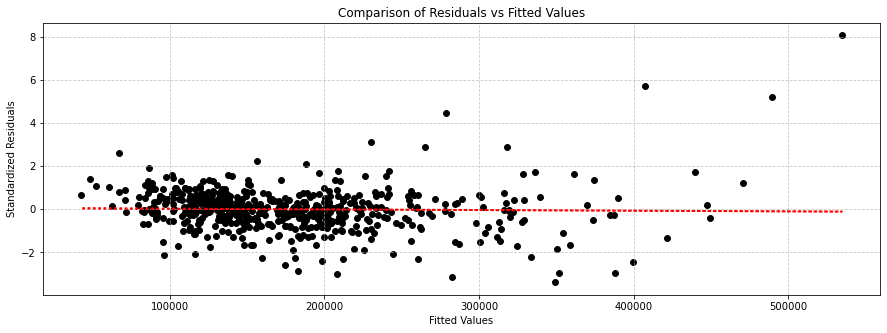

In [60]:
#Plot to check for heteroskedasticity
residuals_array = np.array(residuals).reshape(-1, 1)

scaler          = StandardScaler().fit(residuals_array)
norm_residuals  = scaler.transform(residuals_array)


plt.figure(figsize=(15,5))
plt.grid(True, linestyle='--', alpha=0.7)
plt.title(f"Comparison of Residuals vs Fitted Values")

plt.scatter(y_pred, norm_residuals, c='black', s=35)
plt.xlabel("Fitted Values")
plt.ylabel("Standardized Residuals")


# add trend line  
lin_reg = linear_model.LinearRegression()
lin_reg.fit(y_pred.reshape(-1, 1), norm_residuals)  # Fit to the fitted values
trendline = lin_reg.predict(y_pred.reshape(-1, 1))

# Plot the trendline
plt.plot(y_pred, trendline, color='red', linewidth=2, linestyle='dotted')

/Users/rabab/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


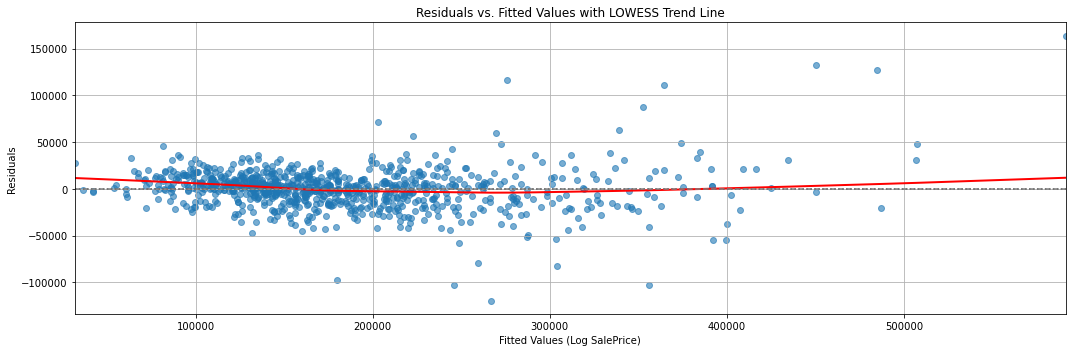

In [61]:
#Testing on ols() model

#Fitting to ols model
X_train_sm = sm.add_constant(X_train)
ols_model = sm.OLS(y_train, X_train_sm).fit()

# Residuals vs. Fitted Values with LOWESS trend line
fitted_vals = ols_model.fittedvalues
residuals = ols_model.resid

plt.figure(figsize=(15, 5))
sns.residplot(x=fitted_vals, y=residuals, lowess=True, 
              line_kws={'color': 'red', 'lw': 2}, 
              scatter_kws={'alpha': 0.6})
plt.axhline(0, color='gray', linestyle='--')
plt.xlabel("Fitted Values (Log SalePrice)")
plt.ylabel("Residuals")
plt.title("Residuals vs. Fitted Values with LOWESS Trend Line")
plt.grid(True)
plt.tight_layout()
plt.show()

In [62]:
# Breusch-Pagan test for heteroskedasticity
bp       = het_breuschpagan(residuals, X_train)
measures = ('LM Statistic', 'LM-Test p-value', 'F-Statistic', 'F-Test p-value')

for measure, value in zip(measures, bp):
    print(f"{measure}: {value}")

LM Statistic: 292.77659166901327
LM-Test p-value: 2.1816574188320703e-14
F-Statistic: 3.019483701264198
F-Test p-value: 2.4112343007210927e-20


<h6 style="color: #ff5733;">Heteroskedasticity Findings:</h6>

1. The model is homoskedastic as the residuals equally distributed across the trendline throughout the test dataset. 
2. Testing against LOWESS line, we see the residuals are still centered around 0, there is noticeable spread and slight non-linearity in the LOWESS line. This suggests the model might be missing some underlying structure in the data or that some non-linear relationships remain unmodeled. The model shows signs of minor misspecification. There’s some mild heteroscedasticity and a non-linear trend in the residuals, implying that additional features or transformations (e.g., polynomial terms or interaction effects) may improve the model fit.
3. This implies that the prediction error does not grow larger as house prices increase.

| Measure | Value | Conclusion |
| :--- | :--- | :--- |
| LM-Test p-value| 9.13 x 10^-7 | Lower than 0.05, confirms there is no heteroskedasticity |
| F-Test p-value | 4.31 x 10^-09 | Lower than 0.05, confirms there is no heteroskedasticity |

**Conclusion:** The model can predict homes more accurately without running into errors at higher numbers

<h5 style="color: blue;">Test: Normal Q-Q</h5>

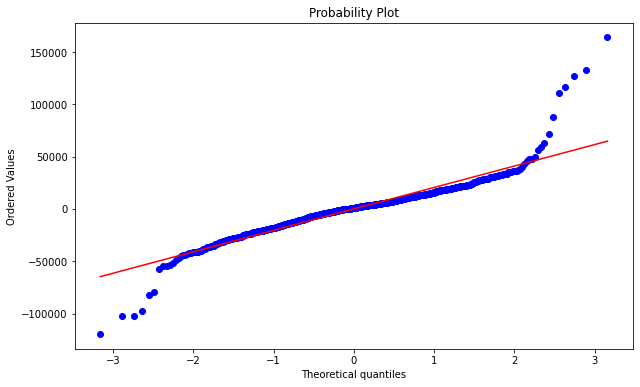

In [63]:
#Creat Q-Q plot
fig = plt.figure(figsize=(10,6))
ax = fig.add_subplot(111)

stats.probplot(residuals, dist = 'norm', plot = ax)
plt.show()


ax.set_title("Normal Q-Q Plot of Residuals")
ax.set_xlabel("Theoretical Quantiles")
ax.set_label("Ordered Values")

<h6 style="color: #ff5733;">Normal Q-Q Findings:</h6>

1. The residuals mostly follow the red line closely, especially in the middle of the distribution (around theoretical quantiles -2 to 2). This suggests that the central part of our distribution aligns with a normal distribution.

2. The deviation at the lower tail (below -2) implies that the lower end of the data has smaller values than expected
3. The deviation at the upper tail (below 2) implies that the higher end of the data has larger values than expected

**Conclusion:** The model predictions aren't entirely normally distributed and outliers 

<h5 style="color: blue;">Test: MAE & RMSE</h5>

In [64]:
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

print(f"""
MAE: {mae:.2f} 
RMSE: {rmse:.2f}
""")


MAE: 17547.58 
RMSE: 26133.64



In [65]:
mean_price = y.mean() 
mae_percent = (mae / mean_price) * 100
rmse_percent = (rmse / mean_price) * 100

print(f"""
MAE is {mae_percent:.1f}% of mean 
RMSE is {rmse_percent:.1f}% of mean
""")


MAE is 9.7% of mean 
RMSE is 14.4% of mean



<h6 style="color: #ff5733;">MAE & RMSE Findings:</h6>

1. The error in the model is **$17,547**. The relative error is 9.7% of the mean (this is an acceptable error in the grand scheme things as house prices are in the range of hundreds of thousands of dollars). 

2. The larger errors in the model are close **$$26,133**. This is 14.4% of the mean sale price. Larger errors could be due to several factors, such as:

- Unpredictable outliers or rare cases (e.g., very expensive properties or unusual market conditions)

- Incomplete or incorrect features in the model that didn't capture certain nuances of the property values.

- Issues like extreme property conditions, unique amenities, or incorrect data points for certain houses.

**Conclusion:** The model is great for house price prediction

### Appendix

In [66]:
#Training flattened - with the model
df1 = pd.concat([X_train, y_train.rename('SalePrice')], axis=1)

path1 = "model_train_data.csv"

df1.to_csv(path1, index=False)

In [ ]:
#Testing flattened - with the model
df2 = pd.concat([X_test, y_test.rename('SalePrice')], axis=1)
df2['Predicted_SalePrice'] = y_pred

path2 = "model_test_data.csv"

df2.to_csv(path2, index=False)

In [ ]:
#Cleaned unflattened model
path3 = "cleaned_training_data.csv"
df_combined.to_csv(path3, index=False)